## Libraries

In [1]:
import warnings
warnings.filterwarnings('ignore')

In [2]:
import tensorflow as tf
tf.compat.v1.logging.set_verbosity(tf.compat.v1.logging.ERROR)

In [3]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import cv2
import random
import time
import os

from deepface import DeepFace

## Constants

In [4]:
DARKNET_PATH = 'darknet'
IMG_SIZE = 416

# Read labels that are used on object
labels = open(os.path.join(DARKNET_PATH, "data", "coco.names")).read().splitlines()
# Make random colors with a seed, such that they are the same next time
np.random.seed(0)
colors = np.random.randint(0, 255, size=(len(labels), 3)).tolist()

In [5]:
image_files = os.listdir('images')

## Image processing

In [6]:
def img2rgb(image):
    return cv2.cvtColor(image, cv2.COLOR_BGR2RGB)

In [7]:
def crop_bounding_box(image, bb):
    x, y, w, h = bb
    return image[y:y+h, x:x+w]

## Plot 

In [8]:
def plot_image(image, title=''):
    fig = plt.figure(figsize=(10, 10))
    plt.title(title)
    plt.imshow(image)
    plt.show()

In [9]:
def draw_bounding_boxes(image_bb, boxes, confidences, class_ids = None):
    for i in range(len(boxes)):
        # Get the box information
        x, y, w, h = boxes[i]
        # Make a rectangle
        color_idx = 0
        if class_ids is not None:
            color_idx = class_ids[i]
        cv2.rectangle(image_bb, (x, y), (x + w, y + h), colors[color_idx], 2)
        # Make and add text
        bb_text = ''
        bb_format = '{}{:.4f}'
        if class_ids is not None:
            bb_text = labels[class_ids[i]]
            bb_format = '{}: {:.4f}'
        text = bb_format.format(bb_text, confidences[i])
        cv2.putText(image_bb, text, (x, y - 5), cv2.FONT_HERSHEY_SIMPLEX,
                    0.5, colors[color_idx], 2)
    return image_bb

In [10]:
def plot_bounding_boxes(image, bb, color = (255, 0, 0)):
    for (x, y, w, h) in bb:
        cv2.rectangle(image, (x, y), (x + w, y + h), color, 3)
    return image

## Bounding boxes processing

In [11]:
def select_best_bounding_boxes(objects_bounding_boxes):
    final_bb = cv2.dnn.NMSBoxes(objects_bounding_boxes.box, objects_bounding_boxes.confidence, 0.3, 0.3).flatten()
    df_best_bb = objects_bounding_boxes.iloc[final_bb].reset_index(drop=True)
    return df_best_bb

## YOLO

In [12]:
def load_net(model_name = 'yolov3-tiny'):
    # Give the configuration and weight files for the model and load the network.
    net = cv2.dnn.readNetFromDarknet(
        os.path.join(DARKNET_PATH, "cfg", model_name+".cfg"),
        os.path.join(DARKNET_PATH, "cfg", model_name+".weights"), 
    )
    # Determine the output layer, now this piece is not intuitive
    ln = net.getLayerNames()
    ln = [ln[i[0] - 1] for i in net.getUnconnectedOutLayers()]
    return (net, ln)

In [13]:
def detect_objects(image):
    net, ln = load_net('yolov3')
    # Get the shape
    h, w = image.shape[:2]
    # Load it as a blob and feed it to the network
    blob = cv2.dnn.blobFromImage(image, 1 / 255.0, (IMG_SIZE, IMG_SIZE), swapRB=True, crop=False)
    net.setInput(blob)
    start = time.time()
    # Get the output
    layer_outputs = net.forward(ln)
    end = time.time()
    return layer_outputs

In [14]:
def extract_output(image, layer_outputs):
    boxes = []
    confidences = []
    class_ids = []
    h, w = image.shape[:2]
    for output in layer_outputs:
        for detection in output:
            scores = detection[5:]
            class_id = np.argmax(scores).item()
            # The maximal score is the confidence
            confidence = scores[class_id].item()
            # Ensure we have some reasonable confidence, else ignorre
            if confidence > 0.3:
                # The first four entries have the location and size (center, size)
                # It needs to be scaled up as the result is given in relative size (0.0 to 1.0)
                box = detection[0:4] * np.array([w, h, w, h])
                center_x, center_y, width, height = box.astype(int).tolist()
                # Calculate the upper corner
                x = center_x - width//2
                y = center_y - height//2
                # Add our findings to the lists
                boxes.append([x, y, width, height])
                confidences.append(confidence)
                class_ids.append(class_id)
    return (boxes, confidences, class_ids)

In [15]:
def get_objects_bounding_boxes(image):
    layer_outputs = detect_objects(image)
    boxes, confidences, class_ids = extract_output(image, layer_outputs)
    objects_bounding_boxes = pd.DataFrame({
        'class_id': class_ids,
        'box': boxes,
        'confidence': confidences,
    })
    if len(objects_bounding_boxes) == 0:
        return (objects_bounding_boxes, image)
    objects_bounding_boxes = select_best_bounding_boxes(objects_bounding_boxes)
    image_bb = draw_bounding_boxes(
        image, 
        objects_bounding_boxes.box, 
        objects_bounding_boxes.confidence, 
        objects_bounding_boxes.class_id
    )
    return (objects_bounding_boxes, image_bb)

## cv2 cascade classifier

In [16]:
def create_cv2_cascade_classifier(model_name):
    model_file = cv2.data.haarcascades + model_name + ".xml"
    cv2cc = cv2.CascadeClassifier(model_file)
    return cv2cc

## Analyze body

## Analyze face

In [17]:
def get_face(image):
    
    # Plot
    # plt.imshow(image)
    # plt.show()
    
    # Detect face
    haar_cascade_face = create_cv2_cascade_classifier('haarcascade_frontalface_default')
    # haar_cascade_profileface = create_cv2_cascade_classifier('haarcascade_profileface')
    faces = haar_cascade_face.detectMultiScale3(
        image, 
        scaleFactor = 1.2, 
        minNeighbors = 2,
        flags = cv2.CASCADE_SCALE_IMAGE,
        outputRejectLevels = True,
    )
    if len(faces[0]) == 0:
        return None
    
    rects = [tuple(x) for x in faces[0]]
    neighbours = [x[0] for x in faces[1]]
    weights = [x[0] for x in faces[2]]
    faces_detected = pd.DataFrame(
        {
            'rects': rects, 
            'neighbours': neighbours, 
            'weights': weights,
        },
    )
    faces_detected.sort_values(by='weights', ascending=False, inplace=True)
    face_bb = faces_detected['rects'].iloc[0]
    
    # Plot
    # plt.imshow(crop_bounding_box(image, face_bb))
    # plt.show()
    
    return face_bb


In [18]:
def analyze_face(face_image):
    filename = 'face_image.png'
    
    # Detect face
    
    # Create image file
    cv2.imwrite(filename, face_image)
    # Deep face analysis
    face_info = DeepFace.analyze(
        filename, 
        actions=['age', 'gender', 'race', 'emotion'],
        enforce_detection=False,
    )
    # TODO
    # Hair color
    # Hair style
    # Beard
    # Moustache
    # Sunglasses
    # Hat
    # Backpack
    
    # Remove image file
    if os.path.exists(filename):
        os.remove(filename)
    # Return face info
    return face_info

## Analyze person

In [19]:
def analyze_person(image):

    # Face
    face_bb = get_face(image)
    face_info = None
    if face_bb is not None:
        (x, y, w, h) = face_bb    
        face_image = image[y : y + h, x : x + w]
        face_info = analyze_face(face_image)

    # Body


    return (face_bb, face_info)

In [20]:
def get_image_from_dataset(image_file = ''):
    data_path = os.listdir(os.path.join(DARKNET_PATH, 'data'))
    data_path = [x for x in data_path if x.split('.')[-1] in ['png', 'jpg', 'jpeg']]
    if image_file == '':
        image_file = random.choice(data_path)
    image = cv2.imread(os.path.join(DARKNET_PATH, "data", image_file))
    image = img2rgb(image)
    return image

In [21]:
def get_person_description(image, person_bb):
    bodies_bb = []
    faces_bb = []
    faces_info = []
    for bb in person_bb:
        body_image = crop_bounding_box(image.copy(), bb)
        face_bb, face_info = analyze_person(body_image)
        if face_bb is not None:
            bodies_bb.append(bb)
            faces_bb.append(face_bb)
            faces_info.append(face_info)
    faces_info = pd.DataFrame(faces_info)
    faces_info['bounding_box'] = faces_bb
    return (bodies_bb, faces_info) 

In [22]:
def plot_multiple_objects(image, bodies_bb, faces_bb, faces_info):     
    n_cols = 3
    n_rows = int(np.ceil(len(faces_bb) / n_cols))
    if n_rows == 0:
        return 
    fig, axs = plt.subplots(nrows=n_rows, ncols=n_cols, figsize=(25, 25))
    index = 0
    for i in range(n_rows):
        for j in range(n_cols):
            if index < len(faces_bb):
                body_bb = bodies_bb[index]
                face_bb = list(faces_bb[index])
                face_bb[0] += body_bb[0]
                face_bb[1] += body_bb[1]
                img_aux = plot_bounding_boxes(image.copy(), [body_bb, face_bb])
                if n_rows > 1:
                    axs[i, j].imshow(img_aux)
                else:
                    axs[index].imshow(img_aux)
                index += 1                
    fig.tight_layout()
    plt.subplots_adjust(left=0.1, bottom=0.1, right=0.9, top=0.9, wspace=0.1, hspace=0.1)
    plt.show()            

## Main

###### 12 GB RAM

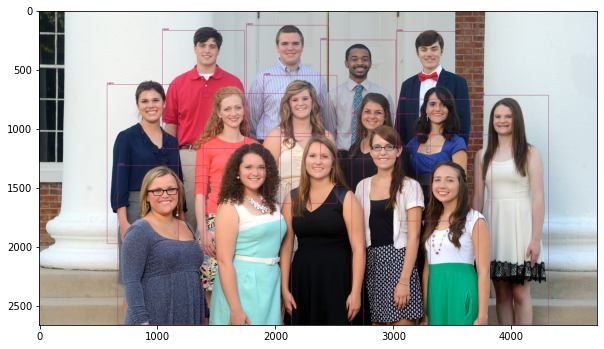

In [23]:
image = get_image_from_dataset('group_5.jpeg')
objects_bounding_boxes, image_bb = get_objects_bounding_boxes(image.copy())

person_bb = objects_bounding_boxes[objects_bounding_boxes['class_id'] == 0]
person_bb = person_bb.drop('class_id', axis=1).reset_index(drop=True)
image_aux = draw_bounding_boxes(image.copy(), person_bb.box, person_bb.confidence)
plot_image(image_aux)

Action: emotion: 100%|██████████| 4/4 [00:00<00:00,  4.46it/s]


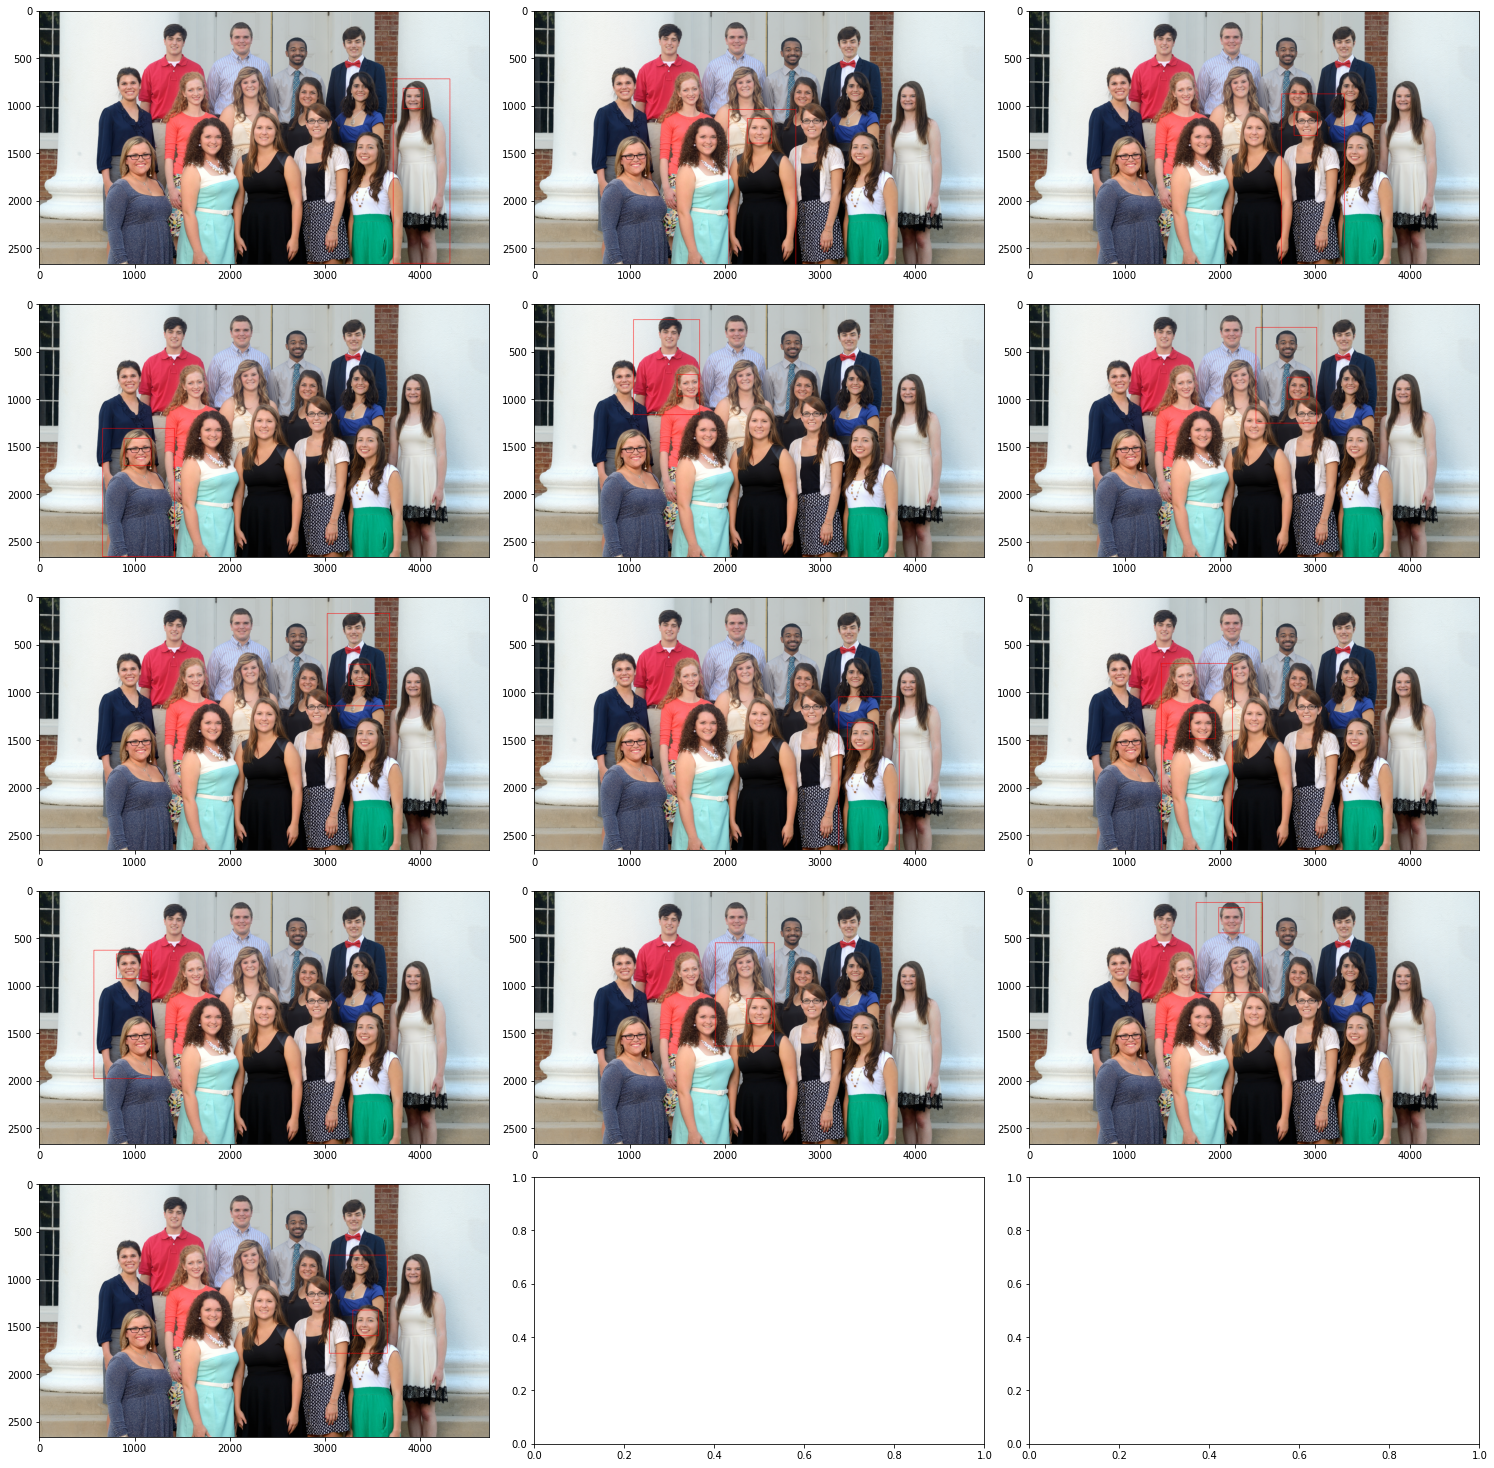

In [24]:
bodies_bb, faces_info = get_person_description(image, person_bb['box'])
plot_multiple_objects(image.copy(), bodies_bb, faces_info['bounding_box'], faces_info)

In [25]:
faces_info

,age,gender,race,dominant_race,emotion,dominant_emotion,bounding_box
0,27.339003,Man,"{'asian': 0.16747645402186834, 'indian': 0.568...",white,"{'angry': 2.4676154453118215e-05, 'disgust': 8...",neutral,"(104, 99, 215, 215)"
1,31.388828,Woman,"{'asian': 2.1057721877521841e-13, 'indian': 1....",white,"{'angry': 2.250089465860583e-05, 'disgust': 2....",happy,"(194, 95, 258, 258)"
2,36.933058,Woman,"{'asian': 15.5369371175766, 'indian': 6.588856...",latino hispanic,"{'angry': 0.012517500689960935, 'disgust': 9.2...",fear,"(134, 190, 246, 246)"
3,32.597557,Woman,"{'asian': 82.9292893409729, 'indian': 0.102512...",asian,"{'angry': 7.952251194599728e-21, 'disgust': 2....",neutral,"(226, 105, 284, 284)"
4,27.401405,Woman,"{'asian': 0.05041109116404302, 'indian': 0.000...",white,"{'angry': 1.3691798346135431e-11, 'disgust': 1...",happy,"(458, 577, 226, 226)"
5,26.970342,Woman,"{'asian': 0.19545177929103374, 'indian': 0.113...",white,"{'angry': 3.3809884534758534e-12, 'disgust': 6...",happy,"(328, 524, 231, 231)"
6,32.782149,Woman,"{'asian': 1.5907961875200272, 'indian': 3.3688...",latino hispanic,"{'angry': 8.375336535415556e-09, 'disgust': 2....",happy,"(229, 533, 225, 225)"
7,25.507628,Woman,"{'asian': 0.40872287936508656, 'indian': 0.095...",white,"{'angry': 0.0018943389947755343, 'disgust': 1....",happy,"(90, 273, 279, 279)"
8,28.494422,Woman,"{'asian': 0.04013649886474013, 'indian': 0.072...",white,"{'angry': 2.928528039207903e-07, 'disgust': 3....",happy,"(295, 520, 272, 272)"
9,24.201699,Woman,"{'asian': 59.86263155937195, 'indian': 2.73515...",asian,"{'angry': 0.0004406474615794142, 'disgust': 2....",happy,"(236, 39, 260, 260)"
